 Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


| Metric                 | Definition                                                        | Purpose                        |
| ---------------------- | ----------------------------------------------------------------- | ------------------------------ |
| **Accuracy**           | $\frac{TP + TN}{TP + TN + FP + FN}$                               | Interpretability               |
| **AUC**                | Area under ROC curve                                              | Classifier quality             |
| **F1 Score**           | $\frac{2PR}{P + R}$, $P = \frac{TP}{TP+FP}, R = \frac{TP}{TP+FN}$ | Balancing precision and recall |
| **Cross-Entropy Loss** | As defined above                                                  | Probabilistic scoring          |
| **Confusion Matrix**   | TP, FP, FN, TN counts                                             | Error analysis                 |


In [ ]:
##set path to data
import os

base_path = '/content/drive/MyDrive/Data science lab project/data'

# Define class folders
class_folders = {
    'AD': os.path.join(base_path, 'AD'),
    'CN': os.path.join(base_path, 'CN')
}


In [ ]:
print("Contents of base_path:")
print(os.listdir(base_path))


Contents of base_path:
['AD', 'CN', 'sMCI', 'pMCI', 'X_AD_CN.npy', 'y_AD_CN.npy']


Original volume shape: (256, 256, 166)


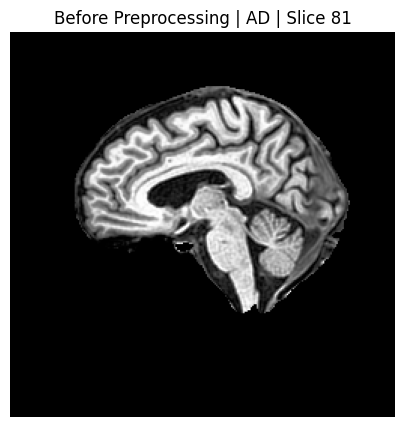

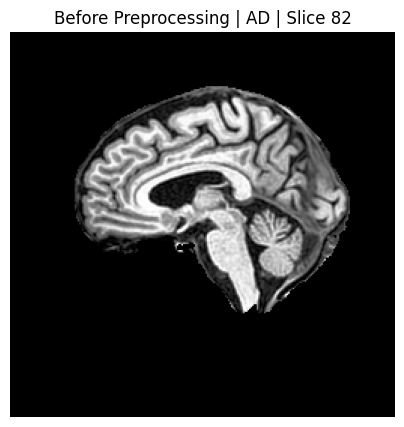

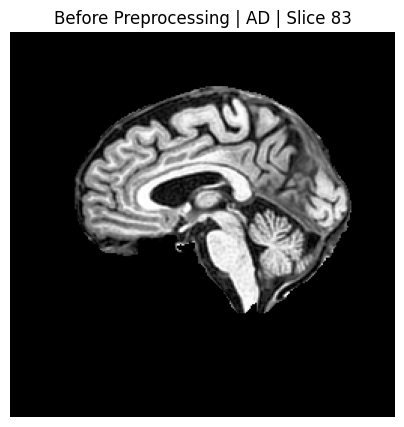

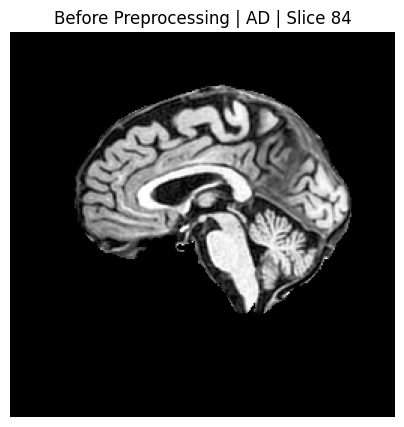

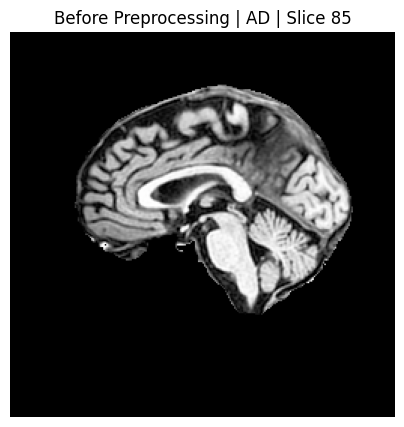

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure
import glob
import os

# Choose class: 'AD' or 'CN'
example_class = 'AD'
example_class_path = class_folders[example_class]

# Pick a sample patient folder and a NIfTI file
patient_dirs = [os.path.join(example_class_path, d) for d in os.listdir(example_class_path) if os.path.isdir(os.path.join(example_class_path, d))]
nii_files = glob.glob(os.path.join(patient_dirs[0], '**', '*.nii*'), recursive=True)

if nii_files:
    nii_path = nii_files[0]
    img = nib.load(nii_path).get_fdata()

    print("Original volume shape:", img.shape)

    # Display 5 slices from the middle (Z-axis)
    middle_slice = img.shape[2] // 2
    for slice_idx in range(middle_slice - 2, middle_slice + 3):
        slice_img = img[:, :, slice_idx]
        slice_img_eq = exposure.equalize_hist(slice_img)

        plt.figure(figsize=(5, 5))
        plt.imshow(slice_img_eq, cmap='gray')
        plt.title(f"Before Preprocessing | {example_class} | Slice {slice_idx}")
        plt.axis('off')
        plt.show()
else:
    print("No NIfTI files found.")


In [ ]:
import os
import glob
import nibabel as nib
import numpy as np
from skimage.transform import resize


##Preprocessing
def preprocess_mri(volume, target_shape=(96,96,96)):
    volume_resized = resize(
        volume,
        target_shape,
        mode='edge',
        preserve_range=True,
        order=1
    )
    volume_norm = (volume_resized - np.mean(volume_resized))
                  / np.std(volume_resized)
    return volume_norm



Preprocessed volume shape: (96, 96, 96)


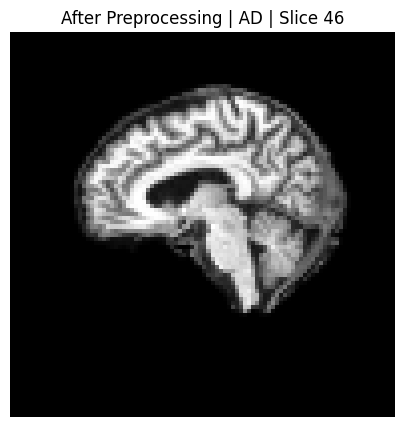

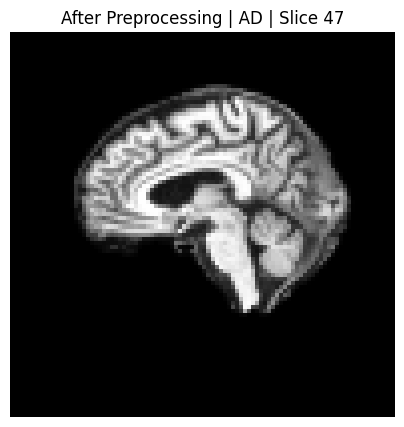

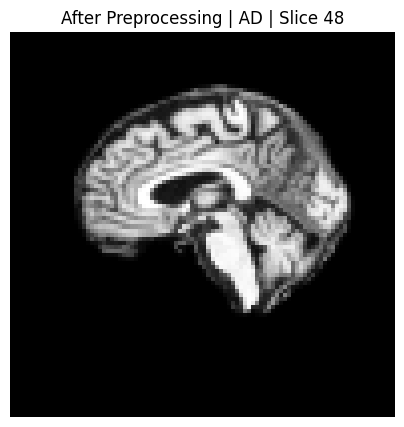

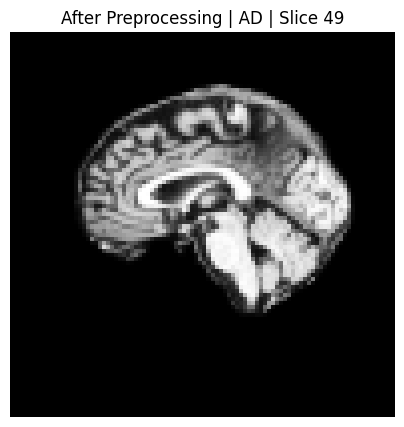

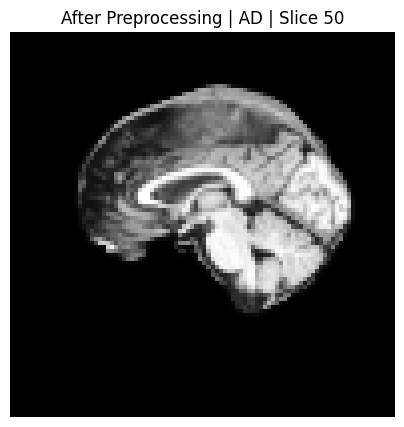

In [ ]:
from skimage.transform import resize

# --- Your preprocessing function ---
def preprocess_mri(volume, target_shape=(96,96,96)):
    volume_resized = resize(volume, target_shape, mode='edge', preserve_range=True, order=1)
    volume_norm = (volume_resized - np.mean(volume_resized)) / np.std(volume_resized)
    return volume_norm

# Apply preprocessing
preprocessed_img = preprocess_mri(img)

print("Preprocessed volume shape:", preprocessed_img.shape)

# Display 5 slices from the middle (Z-axis)
middle_slice = preprocessed_img.shape[2] // 2
for slice_idx in range(middle_slice - 2, middle_slice + 3):
    slice_img = preprocessed_img[:, :, slice_idx]
    slice_img_eq = exposure.equalize_hist(slice_img)

    plt.figure(figsize=(5, 5))
    plt.imshow(slice_img_eq, cmap='gray')
    plt.title(f"After Preprocessing | {example_class} | Slice {slice_idx}")
    plt.axis('off')
    plt.show()


In [ ]:
##define data loading function
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure
import glob
import os
def load_all_mri_data(class_folders, max_patients_per_class=None):
    """
    Loads MRI data for binary classification:
    - AD + pMCI → label 0
    - CN + sMCI → label 1
    """
    data = []
    labels = []

    # Assign label 0 to ['AD', 'pMCI'], label 1 to ['CN', 'sMCI']
    label_map = {
        'AD': 0, 'pMCI': 0,
        'CN': 1, 'sMCI': 1
    }

    for label_name, folder_path in class_folders.items():
        print(f"Loading class: {label_name} from {folder_path}")
        patient_dirs = [
            os.path.join(folder_path, d)
            for d in os.listdir(folder_path)
            if os.path.isdir(os.path.join(folder_path, d))
        ]

        if max_patients_per_class:
            patient_dirs = patient_dirs[:max_patients_per_class]

        for patient_dir in patient_dirs:
            nii_files = glob.glob(os.path.join(patient_dir, '**', '*.nii*'), recursive=True)

            # Only use the first file (optional for memory)
            if nii_files:
                nii_path = nii_files[0]
                try:
                    img = nib.load(nii_path).get_fdata()
                  ##  img = preprocess_mri(img)
                    data.append(img)
                    labels.append(label_map[label_name])
                except Exception as e:
                    print(f"  !!Error loading {nii_path}: {e}")

    data_np = np.array(data)
    labels_np = np.array(labels)
    print(f" Total loaded samples: {len(data_np)}")
    return data_np, labels_np


              Original Labels
               /          \
            CN             AD
           / \            / \
       CN   sMCI     AD   pMCI

   → Combine: CN + sMCI, AD + pMCI


In [ ]:
##load daata

class_folders = {
    'AD': os.path.join(base_path, 'AD'),
    'pMCI': os.path.join(base_path, 'pMCI'),
    'CN': os.path.join(base_path, 'CN'),
    'sMCI': os.path.join(base_path, 'sMCI'),
}

X, y = load_all_mri_data(class_folders)
print("Data shape:", X.shape)
print("Labels shape:", y.shape)

Loading class: AD from /content/drive/MyDrive/Data science lab project/data/AD
Loading class: pMCI from /content/drive/MyDrive/Data science lab project/data/pMCI
Loading class: CN from /content/drive/MyDrive/Data science lab project/data/CN


Volume shape (after squeeze): (96, 96, 96)


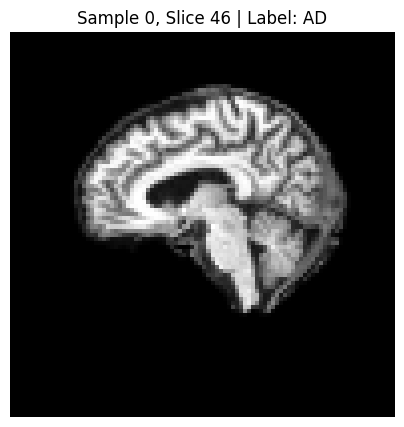

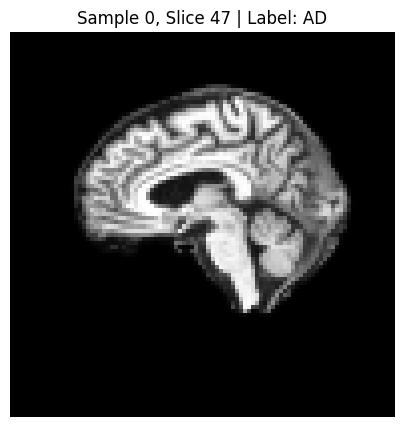

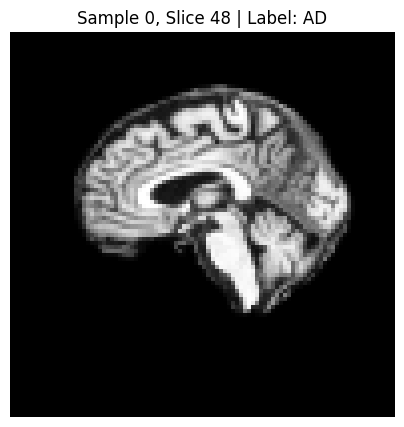

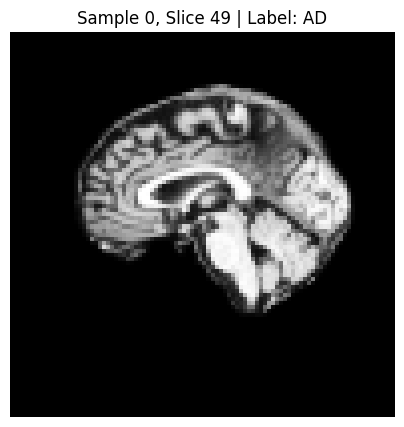

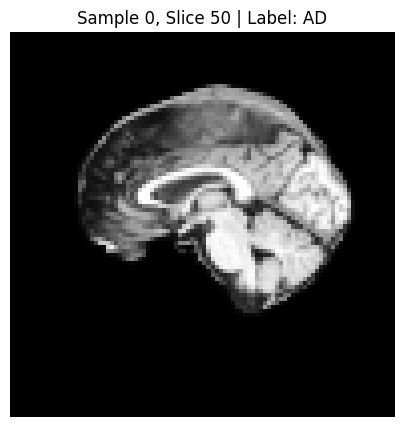

In [ ]:
import matplotlib.pyplot as plt
from skimage import exposure

sample_idx = 0
volume = X[sample_idx]
volume = volume.squeeze()  # remove the channel dimension → (128,128,128)
print("Volume shape (after squeeze):", volume.shape)

# Compute the middle slice along the z-axis (axis 2)
middle_slice = volume.shape[2] // 2

# Display 5 consecutive slices around the middle slice
for slice_idx in range(middle_slice - 2, middle_slice + 3):
    # Use histogram equalization for better contrast in visualization
    slice_img = volume[:, :, slice_idx]
    slice_img_eq = exposure.equalize_hist(slice_img)

    plt.figure(figsize=(5, 5))
    plt.imshow(slice_img_eq, cmap='gray')
    label_str = 'AD' if y[sample_idx] == 0 else 'CN'
    plt.title(f"Sample {sample_idx}, Slice {slice_idx} | Label: {label_str}")
    plt.axis('off')
    plt.show()
